In [1]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from time import time
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)
print("Keras Tuner version:", kt.__version__)

/Users/abhinavgadgil/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


TensorFlow version: 2.19.1
Keras Tuner version: 1.4.8


In [2]:
print("\n" + "="*70)
print("STEP 1: LOADING AND EXPLORING DATA")
print("="*70)

data = load_diabetes()
X, y = data.data, data.target


STEP 1: LOADING AND EXPLORING DATA


In [3]:
print(f"\nDataset shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature names: {data.feature_names}")
print(f"\nTarget statistics:")
print(f"  Mean: {y.mean():.2f}")
print(f"  Std: {y.std():.2f}")
print(f"  Min: {y.min():.2f}")
print(f"  Max: {y.max():.2f}")


Dataset shape: (442, 10)
Target shape: (442,)

Feature names: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

Target statistics:
  Mean: 152.13
  Std: 77.01
  Min: 25.00
  Max: 346.00


In [4]:
print("\n" + "="*70)
print("STEP 2: SPLITTING AND PREPROCESSING DATA")
print("="*70)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

input_dim = X_train_scaled.shape[1]

print(f"\nTraining samples: {X_train_scaled.shape[0]}")
print(f"Test samples: {X_test_scaled.shape[0]}")
print(f"Input features: {input_dim}")


STEP 2: SPLITTING AND PREPROCESSING DATA

Training samples: 353
Test samples: 89
Input features: 10


In [5]:
print("\n" + "="*70)
print("STEP 3: DEFINING MODEL BUILDER")
print("="*70)

def build_model(hp):
    """
    Build a neural network model with tunable hyperparameters
    
    Hyperparameters to tune:
    - Number of hidden layers
    - Units per layer
    - Dropout rate per layer
    - Learning rate
    - Optimizer
    """
    model = keras.Sequential()
    
    # Input layer
    model.add(keras.layers.Input(shape=(input_dim,)))
    
    # Tune number of hidden layers (1-4)
    num_layers = hp.Int('num_layers', min_value=1, max_value=4)
    
    for i in range(num_layers):
        # Tune number of units in each layer
        units = hp.Int(f'units_{i}', min_value=32, max_value=256, step=32)
        model.add(keras.layers.Dense(units=units, activation='relu'))
        
        # Tune dropout rate
        dropout_rate = hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)
        model.add(keras.layers.Dropout(rate=dropout_rate))
    
    # Output layer
    model.add(keras.layers.Dense(1))
    
    # Tune learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # Tune optimizer
    optimizer_name = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    
    if optimizer_name == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae', 'mse']
    )
    
    return model

print("Model builder function defined successfully!")


STEP 3: DEFINING MODEL BUILDER
Model builder function defined successfully!


In [6]:
print("\n" + "="*70)
print("STEP 4: INITIALIZING KERAS TUNER")
print("="*70)

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=15,  # Try 15 different hyperparameter combinations
    executions_per_trial=1,
    directory='keras_tuner_results',
    project_name='diabetes_regression',
    overwrite=True
)

print("\nTuner initialized: RandomSearch")
print(f"Max trials: 15")
print(f"Objective: val_loss (minimize)")

# Display search space
print("\n--- Search Space Summary ---")
tuner.search_space_summary()


STEP 4: INITIALIZING KERAS TUNER

Tuner initialized: RandomSearch
Max trials: 15
Objective: val_loss (minimize)

--- Search Space Summary ---
Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop'], 'ordered': False}


In [7]:
print("\n" + "="*70)
print("STEP 5: SEARCHING FOR BEST HYPERPARAMETERS")
print("="*70)

# Callbacks
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=0
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=0
)

print("\nStarting hyperparameter search...")
print("This may take a few minutes...\n")


STEP 5: SEARCHING FOR BEST HYPERPARAMETERS

Starting hyperparameter search...
This may take a few minutes...



In [9]:
t0 = time()
tuner.search(
    X_train_scaled,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

search_time = time() - t0
print(f"\n✓ Search completed in {search_time:.2f} seconds ({search_time/60:.2f} minutes)")


✓ Search completed in 0.02 seconds (0.00 minutes)


In [10]:
print("\n" + "="*70)
print("STEP 6: RETRIEVING BEST HYPERPARAMETERS")
print("="*70)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps


STEP 6: RETRIEVING BEST HYPERPARAMETERS


In [11]:
print("\n--- Best Hyperparameters ---")
print(f"Number of layers: {best_hps.get('num_layers')}")
print(f"Optimizer: {best_hps.get('optimizer')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")


--- Best Hyperparameters ---
Number of layers: 3
Optimizer: rmsprop
Learning rate: 0.01


In [12]:
for i in range(best_hps.get('num_layers')):
    print(f"\nLayer {i+1}:")
    print(f"  Units: {best_hps.get(f'units_{i}')}")
    print(f"  Dropout: {best_hps.get(f'dropout_{i}'):.1f}")


Layer 1:
  Units: 160
  Dropout: 0.3

Layer 2:
  Units: 224
  Dropout: 0.1

Layer 3:
  Units: 96
  Dropout: 0.1


In [13]:
best_model = tuner.get_best_models(num_models=1)[0]

print("\n--- Best Model Architecture ---")
best_model.summary()


--- Best Model Architecture ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 160)            │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 224)            │        36,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │        21,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,521 (232.50 KB)

 Trainable params: 59,521 (232.50 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
print("\n" + "="*70)
print("STEP 7: EVALUATING BEST MODEL")
print("="*70)

# Evaluate on test set
test_loss, test_mae, test_mse = best_model.evaluate(X_test_scaled, y_test, verbose=0)

# Make predictions
y_pred = best_model.predict(X_test_scaled, verbose=0).flatten()

# Calculate additional metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n--- Test Set Performance ---")
print(f"MSE (Loss): {test_mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {test_mae:.2f}")
print(f"R² Score: {r2:.4f}")


STEP 7: EVALUATING BEST MODEL

--- Test Set Performance ---
MSE (Loss): 3064.98
RMSE: 55.36
MAE: 43.89
R² Score: 0.4215


In [16]:
print("\n" + "="*70)
print("STEP 8: TOP 5 MODELS")
print("="*70)
tuner.results_summary(num_trials=5)



STEP 8: TOP 5 MODELS
Results summary
Results in keras_tuner_results/diabetes_regression
Showing 5 best trials
Objective(name="val_loss", direction="min")

Trial 13 summary
Hyperparameters:
num_layers: 3
units_0: 160
dropout_0: 0.30000000000000004
learning_rate: 0.01
optimizer: rmsprop
units_1: 224
dropout_1: 0.1
units_2: 96
dropout_2: 0.1
units_3: 96
dropout_3: 0.0
Score: 2756.4970703125

Trial 14 summary
Hyperparameters:
num_layers: 3
units_0: 192
dropout_0: 0.0
learning_rate: 0.001
optimizer: rmsprop
units_1: 192
dropout_1: 0.30000000000000004
units_2: 192
dropout_2: 0.2
units_3: 192
dropout_3: 0.2
Score: 2819.7216796875

Trial 02 summary
Hyperparameters:
num_layers: 1
units_0: 128
dropout_0: 0.2
learning_rate: 0.01
optimizer: adam
units_1: 128
dropout_1: 0.2
units_2: 32
dropout_2: 0.4
Score: 2843.890625

Trial 07 summary
Hyperparameters:
num_layers: 2
units_0: 64
dropout_0: 0.30000000000000004
learning_rate: 0.001
optimizer: rmsprop
units_1: 160
dropout_1: 0.0
units_2: 192
dropout_


STEP 9: VISUALIZING RESULTS

✓ Visualization saved as 'keras_tuner_results.png'


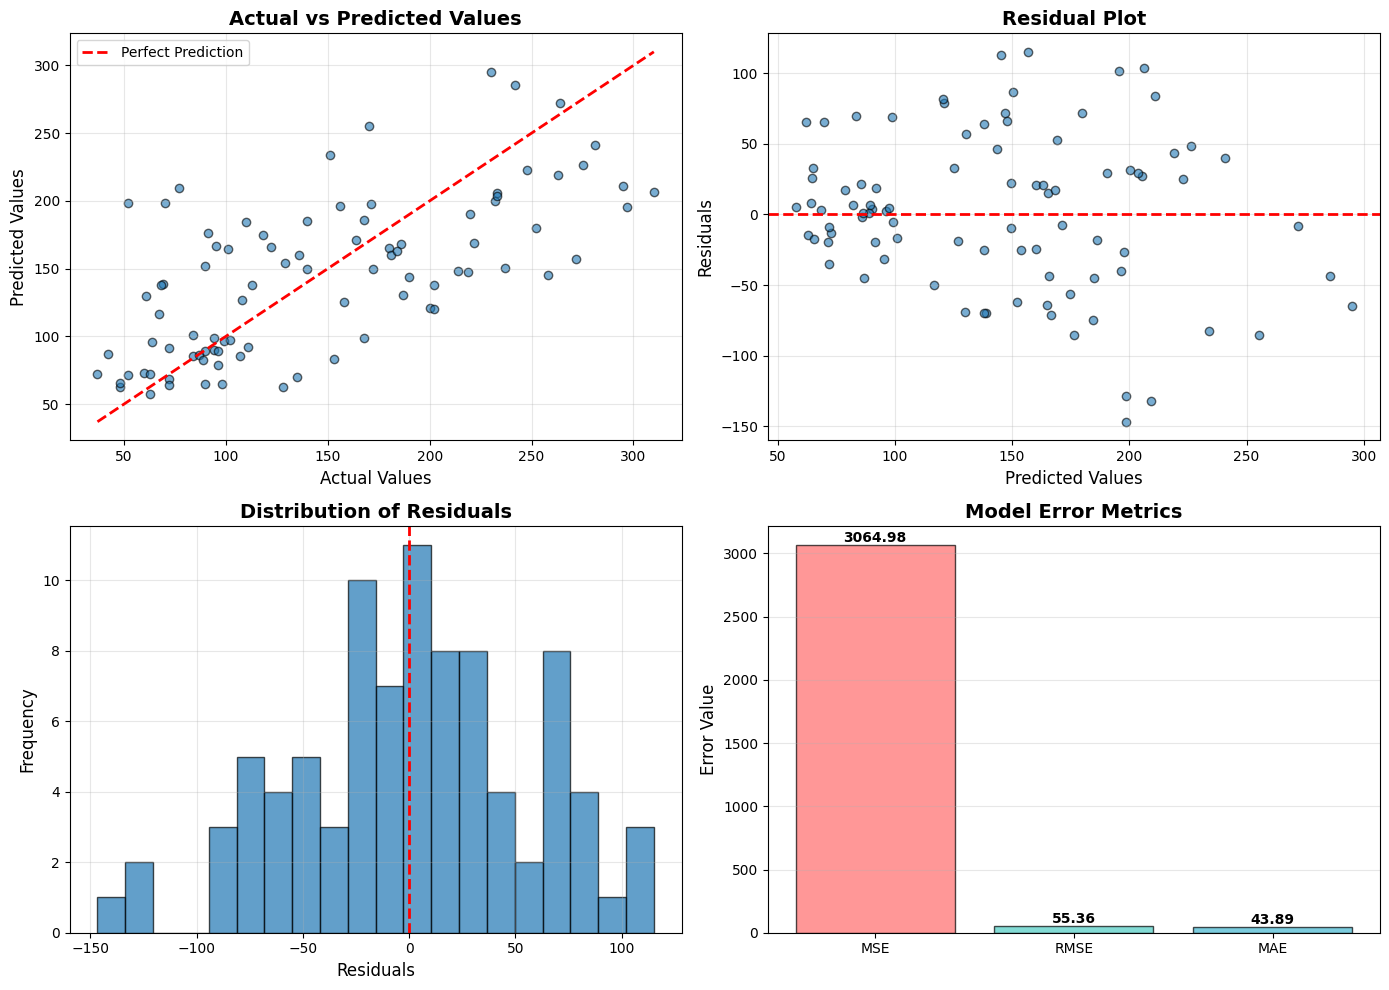

In [18]:
print("\n" + "="*70)
print("STEP 9: VISUALIZING RESULTS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Actual vs Predicted
axes[0, 0].scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Values', fontsize=12)
axes[0, 0].set_ylabel('Predicted Values', fontsize=12)
axes[0, 0].set_title('Actual vs Predicted Values', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Residuals
residuals = y_test - y_pred
axes[0, 1].scatter(y_pred, residuals, alpha=0.6, edgecolors='k')
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Values', fontsize=12)
axes[0, 1].set_ylabel('Residuals', fontsize=12)
axes[0, 1].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Residual Distribution
axes[1, 0].hist(residuals, bins=20, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Residuals', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Distribution of Residuals', fontsize=14, fontweight='bold')
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Error metrics
metrics = ['MSE', 'RMSE', 'MAE']
values = [test_mse, rmse, test_mae]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
bars = axes[1, 1].bar(metrics, values, color=colors, edgecolor='black', alpha=0.7)
axes[1, 1].set_ylabel('Error Value', fontsize=12)
axes[1, 1].set_title('Model Error Metrics', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars, values):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{val:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('keras_tuner_results.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualization saved as 'keras_tuner_results.png'")
plt.show()

In [19]:
print("\n" + "="*70)
print("STEP 10: SAMPLE PREDICTIONS")
print("="*70)

print("\n--- First 10 Predictions ---")
print(f"{'Index':<8} {'Actual':<12} {'Predicted':<12} {'Error':<12}")
print("-" * 50)

for i in range(min(10, len(y_test))):
    error = abs(y_test[i] - y_pred[i])
    print(f"{i:<8} {y_test[i]:<12.2f} {y_pred[i]:<12.2f} {error:<12.2f}")


STEP 10: SAMPLE PREDICTIONS

--- First 10 Predictions ---
Index    Actual       Predicted    Error       
--------------------------------------------------
0        219.00       147.14       71.86       
1        70.00        198.39       128.39      
2        202.00       137.84       64.16       
3        230.00       295.04       65.04       
4        111.00       92.12        18.88       
5        84.00        100.93       16.93       
6        242.00       285.74       43.74       
7        272.00       156.91       115.09      
8        94.00        90.27        3.73        
9        96.00        89.17        6.83        



STEP 11: TRAINING FINAL MODEL

✓ Final model trained successfully!
✓ Training history saved as 'training_history.png'


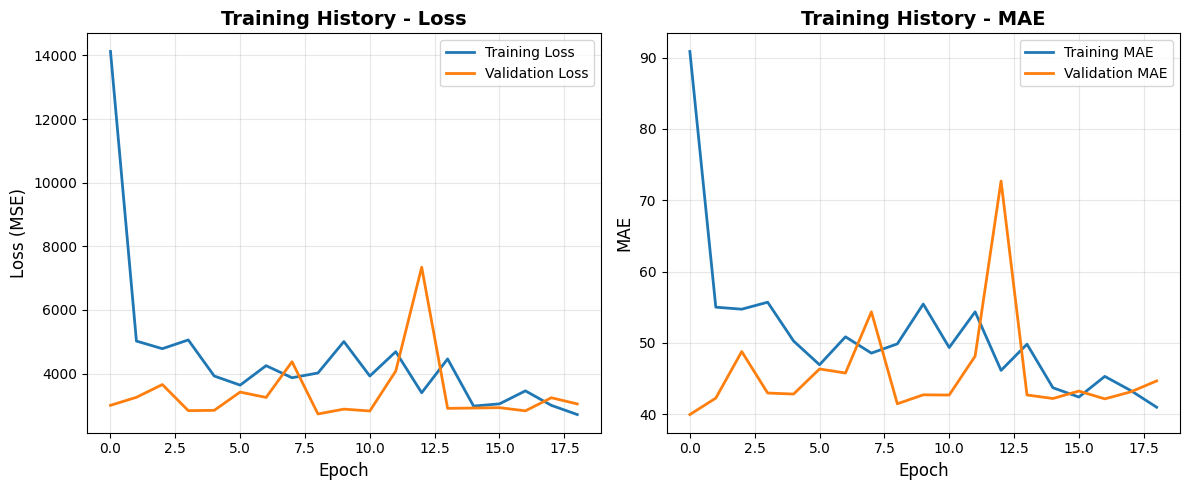

In [20]:
print("\n" + "="*70)
print("STEP 11: TRAINING FINAL MODEL")
print("="*70)

# Build model with best hyperparameters
final_model = tuner.hypermodel.build(best_hps)

# Train with full training data
history = final_model.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

print("\n✓ Final model trained successfully!")

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training History - Loss', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.title('Training History - MAE', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
print("✓ Training history saved as 'training_history.png'")
plt.show()

In [21]:
print("\n" + "="*70)
print("STEP 12: SAVING MODEL")
print("="*70)

final_model.save('best_diabetes_model.keras')
print("✓ Model saved as 'best_diabetes_model.keras'")

# Save hyperparameters
import json
best_hp_dict = {
    'num_layers': best_hps.get('num_layers'),
    'optimizer': best_hps.get('optimizer'),
    'learning_rate': float(best_hps.get('learning_rate')),
}

for i in range(best_hps.get('num_layers')):
    best_hp_dict[f'units_{i}'] = best_hps.get(f'units_{i}')
    best_hp_dict[f'dropout_{i}'] = float(best_hps.get(f'dropout_{i}'))

with open('best_hyperparameters.json', 'w') as f:
    json.dump(best_hp_dict, f, indent=4)

print("✓ Hyperparameters saved as 'best_hyperparameters.json'")



STEP 12: SAVING MODEL
✓ Model saved as 'best_diabetes_model.keras'
✓ Hyperparameters saved as 'best_hyperparameters.json'


In [24]:
print(f"""
✓ Dataset: Diabetes (442 samples, 10 features)
✓ Train/Test Split: 80/20
✓ Hyperparameter Search: Completed ({search_time:.2f} seconds)
✓ Best Model Performance:
    - MSE: {test_mse:.2f}
    - RMSE: {rmse:.2f}
    - MAE: {test_mae:.2f}
    - R² Score: {r2:.4f}

✓ Files Generated:
    - best_diabetes_model.keras
    - best_hyperparameters.json
    - keras_tuner_results.png
    - training_history.png

✓ Keras Tuner Directory: keras_tuner_results/diabetes_regression/
""")


✓ Dataset: Diabetes (442 samples, 10 features)
✓ Train/Test Split: 80/20
✓ Hyperparameter Search: Completed (0.02 seconds)
✓ Best Model Performance:
    - MSE: 3064.98
    - RMSE: 55.36
    - MAE: 43.89
    - R² Score: 0.4215

✓ Files Generated:
    - best_diabetes_model.keras
    - best_hyperparameters.json
    - keras_tuner_results.png
    - training_history.png

✓ Keras Tuner Directory: keras_tuner_results/diabetes_regression/

